In [50]:
#Plot the result of a 3 one-vs-rest explanations in the probability space for a 3 classes example

import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, ilr_inv, sbp_basis, inner
from math import sqrt


In [32]:
K = 13         #index of the instance you want to test in the test set
N_class = 3    #number of class, the dimension of the simplex is therefore N_class-1


#load the dataset and split into a training and testing set
data = datasets.load_iris()
(X, Y) = (data.data, data.target)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X)
X = scaler.transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [48]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

def predict_onevsrest(predict_proba,class_to_evaluate):
    #Transform a predict_proba function into a one-vs-rest predict_proba
    def ovr(X):
        pred= predict_proba(X)
        return np.array([pred[:,class_to_evaluate], 1-pred[:,class_to_evaluate]]).transpose()
    return ovr

# 3 independent explaination of the predictions in a one-vs-rest setting for class i
Shapley = []
Base    = []
for i in range(3):
    predict_proba = predict_onevsrest(svc_linear.predict_proba, i)
    explainer = ShapleyExplainer(predict_proba, X_train, 2,
                            names_classes=[data.target_names[i],'rest'],
                            names_features=['sep. length','sep. width','pet. length','pet. width'])
    (shapley, base) = explainer.explain_instance(np.array(X_test[K]))
    Shapley.append(shapley)
    Base.append(base)
Base    = np.array(Base)
Shapley = np.array(Shapley).squeeze().transpose()

print(Base)
print(Shapley)

[[ 1. -1.]]
[[ 1. -1.]]
[[ 1. -1.]]
[-1.31367609 -1.16051843 -0.94585149]
[[-0.28325722  0.22430517  0.11568799]
 [-0.30946345 -0.03197688  0.19483459]
 [-0.60908267  0.82035057 -0.08655855]
 [-0.5931938   1.11281385 -0.29742943]]


In [51]:
#cumulative sum of the Shapley logit-vectors with the base

cum_sum = []
for i in range(len(Shapley)):
    cum_sum.append(Base + Shapley[0:i+1,:].sum(axis=0))

cum_sum = np.array(cum_sum)
print(cum_sum)

pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print(np.log(pred/(1-pred))/sqrt(2))

[[-1.5969333  -0.93621326 -0.8301635 ]
 [-1.90639675 -0.96819014 -0.63532891]
 [-2.51547943 -0.14783957 -0.72188745]
 [-3.10867323  0.96497428 -1.01931689]]
[[-3.10867324  0.9649743  -1.01931687]]


[0.13495752 0.162299   0.20789909]


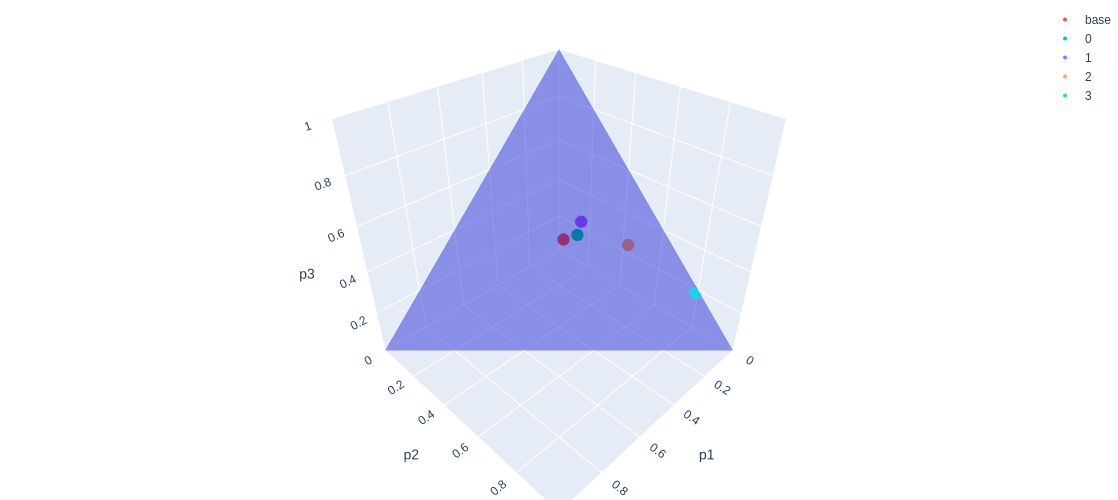

In [59]:

#Plot the probability simplex       
fig = go.Figure(layout=go.Layout(autosize=False, width=500, height=500))
fig.update_layout(legend=dict(bgcolor='rgba(255,255,255,0.4)', yanchor="top", y=0.99, xanchor="right", x=1),
                              margin=dict(l=0, r=0, t=0, b=0),
                              scene = dict(xaxis = dict(title="p1", range=[0,1]),
                                           yaxis = dict(title="p2", range=[0,1]),
                                           zaxis = dict(title="p3", range=[0,1])))


fig.add_trace(go.Mesh3d(x=[1,0,0], y=[0,1,0], z=[0,0,1], opacity=0.4, color='blue', i=np.array([0]), j=np.array([1]), k=np.array([2]) ))


#Plot the cumulative sum points in the probability space
def s(x):
    return 1/(1+np.exp(-sqrt(2)*x))

base_prob = s(Base)
print(base_prob)
cum_sum_prob = s(cum_sum)

#base
fig.add_trace(go.Scatter3d(x=[base_prob[0]], y=[base_prob[1]], z=[base_prob[2]], mode='markers', marker={'size' : 4}, name='base'))
for i in range(len(cum_sum)):
    fig.add_trace(go.Scatter3d(x=[cum_sum_prob[i,0]], y=[cum_sum_prob[i,1]], z=[cum_sum_prob[i,2]], mode='markers', marker={'size' : 4}, name=str(i)))

fig.show()
